##### This notebook plots different AR maps of the HALO-(AC)3 cases from RF05 and RF06. The first plot is used in Wendisch et al. (2024), while the following three figures constititues those included in the AR moisture budget paper of Dorff et al. (2024).

In [1]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Configurations

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

base_path=os.getcwd()+"/../../../"
work_path=base_path+"/Work/GIT_Repository/"
synth_git_path=base_path+"/my_GIT/Synthetic_Airborne_Arctic_ARs/"
budget_script_path=base_path+"/my_GIT/HALO_AC3_AR_Budget_Closure/scripts/"
src_path=synth_git_path+"/src/"
src_plot_path=synth_git_path+"/plotting/"
ac3_plotting_path=budget_script_path+"/../plotting/"
print("SRC_plotting_path",src_plot_path)
sys.path.insert(1,synth_git_path)
sys.path.insert(2,src_path)
sys.path.insert(3,src_plot_path)
sys.path.insert(4,work_path)
sys.path.insert(5,budget_script_path)
sys.path.insert(6,ac3_plotting_path)

airborne_data_path=work_path+"hamp_processing_py\\hamp_processing_python\\"#\\Flight_Data\\HALO_AC3\\sea_ice\\"
airborne_importer_path=airborne_data_path#actual_working_path+"/../../"+desired_path_str
import flightcampaign
import data_config
import Performance

performance=Performance.performance()
name="data_config_file"
config_file_exists=False
campaign_name="HALO_AC3"  
flights=["RF05"]
met_variable="IVT"
should_plot_era_map=True
# Check if config-File exists and if not create the relevant first one
if data_config.check_if_config_file_exists(name):
    config_file=data_config.load_config_file(work_path,name)
else:
    data_config.create_new_config_file(file_name=name+".ini")
system_is_windows=True

if system_is_windows:
        if not config_file["Data_Paths"]["system"]=="windows":
            windows_paths={
                "system":"windows",
                "campaign_path":os.getcwd()+"/"    
                    }
            windows_paths["save_path"]=windows_paths["campaign_path"]+"Save_path/"
            data_config.add_entries_to_config_object(name,windows_paths)
        


is_flight_campaign=True
cmpgn_cls=flightcampaign.HALO_AC3(is_flight_campaign=True,
        major_path=config_file["Data_Paths"]["campaign_path"],
        aircraft="HALO",interested_flights=[flights[0]],
        instruments=["radar","radiometer","sonde"])
cmpgn_cls.specify_flights_of_interest(flights)
use_era5_ARs=True

SRC_plotting_path C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../..//my_GIT/Synthetic_Airborne_Arctic_ARs//plotting/


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Config-file data_config_file.ini  already exists
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../..//Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../..//Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3


In [3]:
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


## Plotting functions

In [4]:
from reanalysis import ERA5
from ICON import ICON_NWP as ICON

campaign_cls=cmpgn_cls
flight=flights[0]
# Define the plot specifications for the given variables

met_var_dict={}
met_var_dict["ERA_name"] = {"IWV":"tcwv","IVT":"IVT",
                           "IVT_u":"IVT_u","IVT_v":"IVT_v"}
met_var_dict["colormap"] = {"IWV":"density","IVT":"ocean_r",
                           "IVT_v":"speed",
                           "IVT_u":"speed"}
met_var_dict["levels"]   = {"IWV":np.linspace(10,25,101),
                           "IVT":np.linspace(50,500,101),
                           "IVT_v":np.linspace(0,500,101),
                           "IVT_u":np.linspace(0,500,101)}
met_var_dict["units"]    = {"IWV":"(kg$\mathrm{m}^{-2}$)",
                           "IVT":"(kg$\mathrm{m}^{-1}\mathrm{s}^{-1}$)",
                           "IVT_v":"(kg$\mathrm{m}^{-1}\mathrm{s}^{-1}$)",
                           "IVT_u":"(kg$\mathrm{m}^{-1}\mathrm{s}^{-1}$)"}

flight_date=campaign_cls.year+"-"+campaign_cls.flight_month[flight]
flight_date=flight_date+"-"+campaign_cls.flight_day[flight]


era5=ERA5(for_flight_campaign=True,campaign=campaign_cls.name,
      research_flights=flight,
      era_path=campaign_cls.campaign_path+"/data/ERA-5/")
plot_path=campaign_cls.campaign_path+"/plots/"+flight+"/"
campaign_cls.plot_path=plot_path
hydrometeor_lvls_path=campaign_cls.campaign_path+"/data/ERA-5/"

file_name="total_columns_"+campaign_cls.year+"_"+\
                        campaign_cls.flight_month[flight]+"_"+\
                        campaign_cls.flight_day[flight]+".nc"    

ds,era_path=era5.load_era5_data(file_name)

ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)



# Load Flight Track
halo_dict={}
cmpgn_cls.load_AC3_bahamas_ds(flight)
halo_dict=cmpgn_cls.bahamas_ds

if isinstance(halo_dict,pd.DataFrame):
    halo_df=halo_dict.copy() 
elif isinstance(halo_dict,xr.Dataset):
    halo_df=pd.DataFrame(data=np.nan,columns=["alt","Lon","Lat"],
                    index=pd.DatetimeIndex(np.array(halo_dict["TIME"][:])))
    halo_df["Lon"]=halo_dict["IRS_LON"].data
    halo_df["Lat"]=halo_dict["IRS_LAT"].data
    if len(halo_dict.keys())==1:
        halo_df=halo_dict.values()[0]
else:   
        halo_df=pd.concat([halo_dict["inflow"],halo_dict["internal"],
                           halo_dict["outflow"]])
        halo_df.index=pd.DatetimeIndex(halo_df.index)

halo_df["Hour"]=halo_df.index.hour
halo_df=halo_df.rename(columns={"Lon":"longitude",
                        "Lat":"latitude"})
date=str(halo_df.index.date[0])
flight_date_int=''.join(date.split("-"))

## Sea-ice

In [5]:
def extract_and_add_date(file):
    date=date=file[-16:-8]
    grid_time = pd.to_datetime(date)
    return ds.assign(time=grid_time)

def add_time_dim(xda):
    from datetime import datetime
    xda = xda.expand_dims(time = [datetime.now()])
    return xda    

use_amsr2_sea_ice=True
draw_multibox=True
amsr2_sea_ice_path=airborne_importer_path+"Flight_Data\\HALO_AC3\\sea_ice\\"
import glob
sea_ice_file_list=glob.glob(amsr2_sea_ice_path+"*"+flight_date_int+"*.nc")
sea_ice_ds=xr.open_dataset(sea_ice_file_list[0])
seaice=sea_ice_ds["seaice"]

## ICON

In [6]:
# load hydrometeor ICON files for precipitation
central_hour="12"
ar_of_day="AR_entire_1"
# IWV, Precip and so on
# Vertical profiles
icon_major_path       = work_path+campaign_name+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path =work_path+campaign_name+"/data/ICON_LEM_2KM/"
flight_list=[flight]
icon_resolution=2000 # units m
upsample_time="10min"
icon_var_list=ICON.lookup_ICON_AR_period_data(campaign_name,flight_list,ar_of_day,
                                         icon_resolution,
                                         hydrometeor_icon_path,
                                         synthetic=False)
interp_icon_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv"

import gridonhalo as Grid_on_HALO

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
                    cmpgn_cls,icon_var_list,halo_df,flight_list,date,
                    interpolated_hmp_file=interp_icon_hmp_file,
                    interpolated_hmc_file=None,ar_of_day=ar_of_day,
                    upsample_time=upsample_time,
                    synthetic_icon=False,
                    synthetic_flight=False)

hydrometeor_icon_path=hydrometeor_icon_path+flight+"/"
ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)

icon_var_dict={}
# read the data
for var in ["Pressure","Specific_humidity","U_wind","V_wind","Z_height"]:
    print(var)
    hour="12"
    icon_q_file=var+"_"+ICON_on_HALO.flight+"_"+\
                            ICON_on_HALO.ar_of_day+"_"+hour+"UTC.nc"
    icon_ds=xr.open_dataset(ICON_on_HALO.hydrometeor_icon_path+\
                            icon_q_file)
    icon_ds=icon_ds.astype(np.float32)
    if not var=="Z_height":
        icon_ds=icon_ds.isel({"time":0})
    icon_var_dict[var]=icon_ds.copy()
    del icon_ds

Pressure
Specific_humidity
U_wind
V_wind
Z_height


In [7]:
# Calc IVT
g= 9.81
ivt_threshold=250
add_icon=False

q_loc= pd.DataFrame(data=np.array(icon_var_dict["Specific_humidity"]["qv"].values[:].T),
                        index=np.array(icon_var_dict["Specific_humidity"].ncells.values[:]),
                        columns=np.array(icon_var_dict["Specific_humidity"].height.values[:]))
u_loc= pd.DataFrame(data=np.array(icon_var_dict["U_wind"]["u"].values[:].T),
                        index=np.array(icon_var_dict["U_wind"]["u"].ncells.values[:]),
                        columns=np.array(icon_var_dict["U_wind"]["u"].height.values[:]))
v_loc= pd.DataFrame(data=np.array(icon_var_dict["V_wind"]["v"].values[:].T),
                        index=np.array(icon_var_dict["V_wind"]["v"].ncells.values[:]),
                        columns=np.array(icon_var_dict["V_wind"]["v"].height.values[:]))
if add_icon:
    qu=q_loc*u_loc
    qv=q_loc*v_loc
    pres=pd.DataFrame(data=np.array(icon_var_dict["Pressure"]["pres"].values[:].T),
                            index=np.array(icon_var_dict["Pressure"]["pres"].ncells.values[:]),
                            columns=np.array(icon_var_dict["Pressure"]["pres"].height.values[:]))

    icon_ivt=pd.DataFrame(data=np.nan,
                          index=u_loc.index,
                          columns=["IVT","IWV_calc","IVT_u","IVT_v","lat","lon"])
    range_index=u_loc.shape[0]#1000100000u_loc.shape[0]
    for ts in range(range_index):
        icon_ivt["IWV_calc"].iloc[ts]= 1/g*np.trapz(q_loc.iloc[ts,:].dropna(),x=pres.iloc[ts,:].dropna())
        icon_ivt["IVT_u"].iloc[ts] = 1/g*np.trapz(qu.iloc[ts,:].dropna(),x=pres.iloc[ts,:].dropna())

        icon_ivt["IVT_v"].iloc[ts] = 1/g*np.trapz(qv.iloc[ts,:].dropna(),x=pres.iloc[ts,:].dropna())
        performance.updt(range_index, ts)

    icon_ivt["lon"]=icon_var_dict["U_wind"].clon.values
    icon_ivt["lat"]=icon_var_dict["U_wind"].clat.values

    icon_ivt["IVT"]   = np.sqrt(icon_ivt["IVT_u"]**2+icon_ivt["IVT_v"]**2)
    icon_ivt["IWV_calc"].max()
else:
    print("Testing")
    icon_ivt=pd.DataFrame(data=500,
                index=u_loc.index,
                columns=["IVT","IWV_calc","IVT_u","IVT_v","lat","lon"])
    


Testing


## Dropsondes

In [8]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
with HiddenPrints():
    halo_era5,halo_ar_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight_list,config_file_path=work_path,ar_of_day=ar_of_day)

In [9]:
# Get relevant sondes
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))
relevant_sondes_dict={}
internal_sondes_dict={}

relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
relevant_cold_sector_sondes=[4,5,6]
relevant_warm_internal_sondes=[7,13]
relevant_sondes_dict["warm_sector"]        = {}
relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
relevant_sondes_dict["cold_sector"]        = {}
relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
#relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
synthetic_sonde_times_series=pd.Series(data=["7synth","8synth","9synth"],
                         index=pd.DatetimeIndex(["2022-03-15 12:55","2022-03-15 13:05","2022-03-15 13:15"]))
relevant_sondes_dict["cold_sector"]["out"] = synthetic_sonde_times_series
internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
internal_sondes_dict["cold"]               = ["2022-03-15 11:30:00","2022-03-15 13:35"]   

## Plotting

In [10]:
import AR_mapper as ARmaps

AR_mapper=ARmaps.AR_mapper(campaign_cls,flight,config_file,seaice,halo_df,ar_of_day)

#### Budget contributions

In [11]:
# CAUTION old values for AR RF05 and Sector 1
halo_sonde_values={}
halo_sonde_values["RF05_AR_entire_1"]={'mass_div': 0.320,
  'mass_div_min' : 0.056,
  'mass_div_max' : 0.323,
  'mass_div_unc' :0.05606615583661565,
  'q_ADV': 0.162,
  'q_ADV_min': -0.42,
  'q_ADV_max': 0.74,
  'q_ADV_unc':0.139}

icon_sonde_values={}
icon_sonde_values["RF05_AR_entire_1"]={'mass_div': 0.36,
  'mass_div_min' : np.nan,
  'mass_div_max' : np.nan,
  'mass_div_unc' : 0.05,   ##---> preliminary
  'q_ADV': 0.09,
  'q_ADV_min': np.nan,
  'q_ADV_max': np.nan,  ## ---> preliminary
  'q_ADV_unc':0.15}

In [12]:
sector="S1"
rate_path =cmpgn_cls.campaign_path+"/data/precip_rates/"
rate_fname="warm"+"_precip_"+flight+"_"+ar_of_day+".csv"
halo_precip_rates=pd.read_csv(rate_path+rate_fname,index_col=0)
halo_precip_rates["Sector"]=sector
interp_icon_hmp_file=flight+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
interp_icon_ivt_file=flight+"_"+ar_of_day+"_"+"ICON_Interpolated_IVT.csv"
halo_icon_ivts=pd.read_csv(hydrometeor_icon_path+interp_icon_ivt_file,index_col=0)
halo_icon_ivts["Sector"]=sector
halo_icon_ivts
halo_icon_hmps=pd.read_csv(hydrometeor_icon_path+interp_icon_hmp_file,index_col=0)
warm_icon_rain=halo_icon_hmps.loc[halo_precip_rates.index]
warm_icon_rain.quantile([0.1,0.9])["Interp_Precip"].iloc[-1]
warm_icon_rain["Interp_Precip"].mean()

#ICON_on_HALO.load_interpolated_hmp()
#halo_icon_hmps["Sector"]=sector

0.06009434826485853

In [13]:
halo_precip_rates.index=pd.DatetimeIndex(halo_precip_rates.index)
merged_precipitation=halo_precip_rates.resample("10s").mean()
merged_precipitation["min_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].min(axis=1)
merged_precipitation["max_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].max(axis=1)
merged_precipitation["min_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].min(axis=1)
merged_precipitation["max_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].max(axis=1)
merged_precipitation["min_rate"]=merged_precipitation["min_rain"]+merged_precipitation["min_snow"]
merged_precipitation["max_rate"]=merged_precipitation["max_rain"]+merged_precipitation["max_snow"]
merged_precipitation.quantile([0.1,0.9])

,r_norris,r_palmer,r_chandra,s_schoger,s_matrosov,s_heymsfield,mean_snow,mean_rain,mean_unc,surface,...,min_mixed,rate,lat,lon,min_rain,max_rain,min_snow,max_snow,min_rate,max_rate
0.1,0.005498,0.011856,0.019759,0.000445,0.000584,0.011504,0.000000,0.000000,NaN,0.0,...,0.0,0.00000,74.554256,-4.640644,0.005498,0.019759,0.000445,0.011504,NaN,NaN
0.9,0.073820,0.129002,0.612990,0.006661,0.009160,0.064146,0.015635,0.117066,NaN,0.0,...,0.0,0.13226,75.403911,8.379262,0.073820,0.612990,0.006661,0.064146,NaN,NaN


In [14]:
icon_ivt["IVT"][icon_ivt["IVT"]<ivt_threshold]=np.nan

Hour of the day: 9
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/S1_AR_Budget_components_intercomparison_HALO_ICON.png


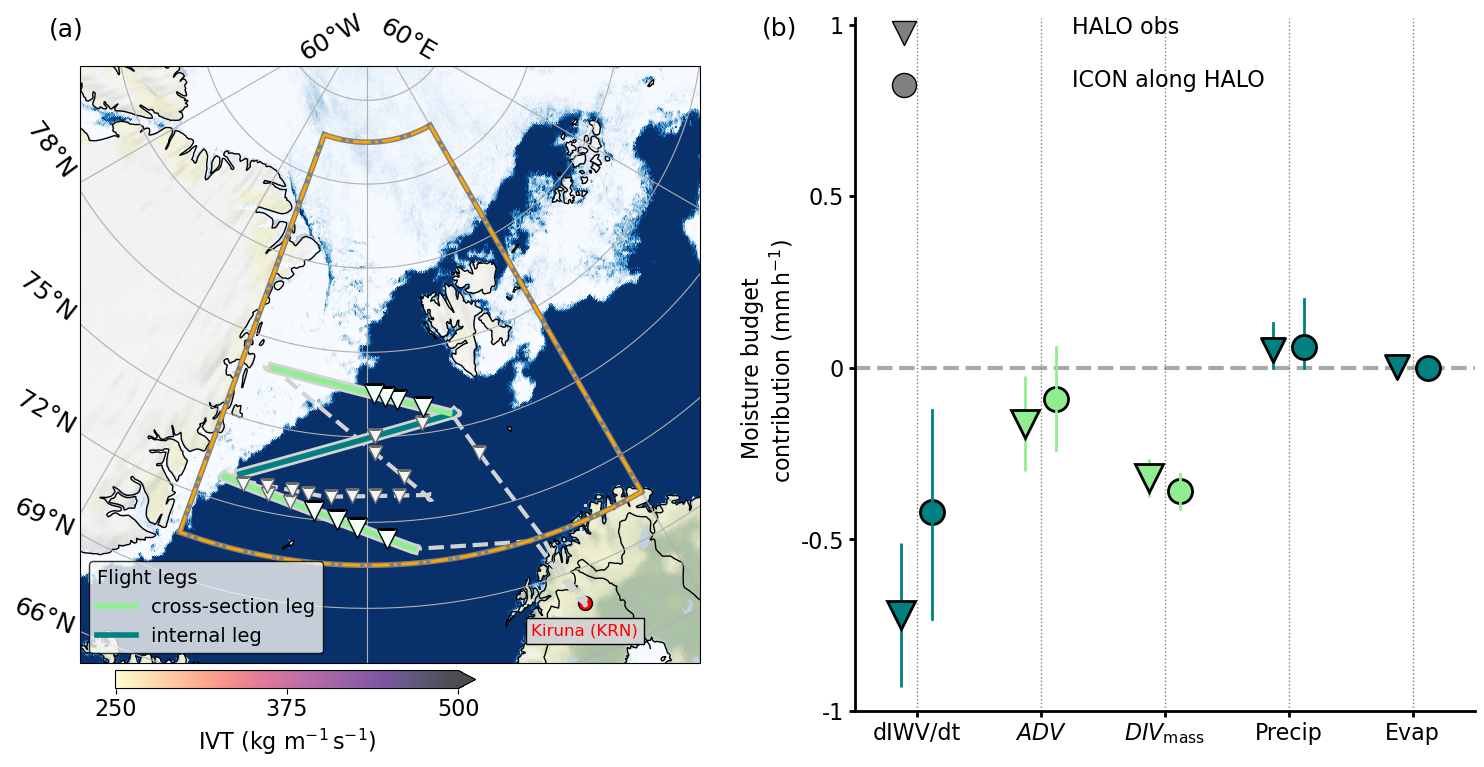

In [15]:
AR_mapper.plot_AR_map_with_budget_HALO_ICON_comparison(era5,icon_ivt,Dropsondes,relevant_sondes_dict,internal_sondes_dict,
            warm_icon_rain,merged_precipitation,halo_sonde_values,icon_sonde_values,ivt_threshold=ivt_threshold)

Figure 9: Realisation of airborne derivation of moisture budget components of a specific section in the atmospheric river that was sampled during RF05 (grey dashed lines). For the ICON domain (orange dashed region), simulated IVT values above 250 kg m-1 s-1 are specified in the colourmap. From the flight, two different types of legs allow to derive the moisture budget components (green colour-coded in Fig. a). The two cross-section legs (lightgreen in a) characterise the in- and outgoing IVT for the encompassed flight corridor and AR section. IVT values from the dropsondes (indicated as triangles) enable the derivation of the IVT divergence that is given by the sum of moisture advection (ADV) and mass divergence (DIV_mass) in b). Along the internal leg inside the section (teal-colour flight section), precipitation rate (Precip) is derived from the radar, as well as evaporation and water vapour load, i.e its local tendency from the dropsondes and HAMP respectively. For the eastern half of the AR, b) compares the moisture budget components derived from HALO (triangles) to those from ICON along the HALO track (circles) regarding their contribution to the moisture budget in mm/h. Vertical lines indicate the error bars for each component.
Sea ice cover in a) is given by the AMSR-2 sea ice product (Spreen, 2008).

### Plot AR synoptical conditions RF05

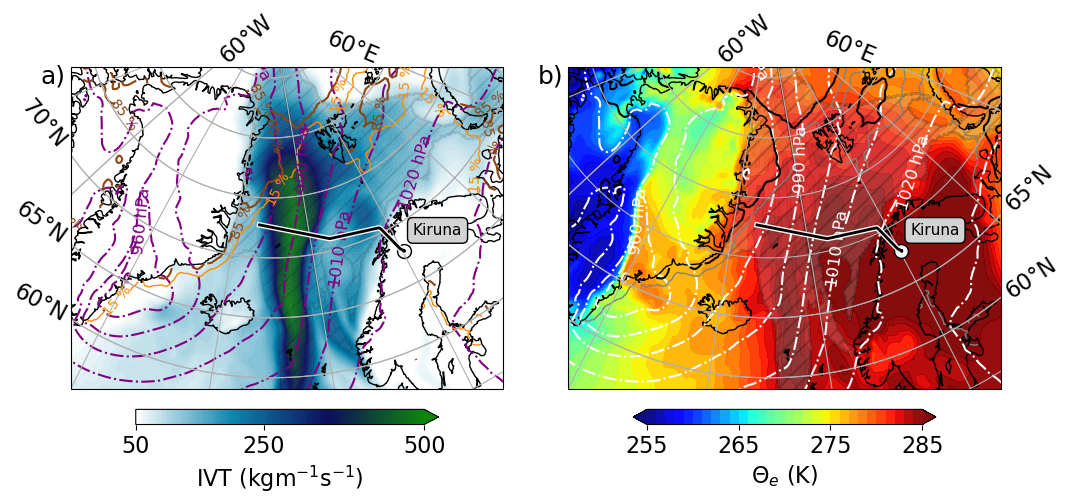

In [16]:
with HiddenPrints():
    AR_mapper.plot_AR_synoptics()

### Plot AR IVT tendency RF05/RF06

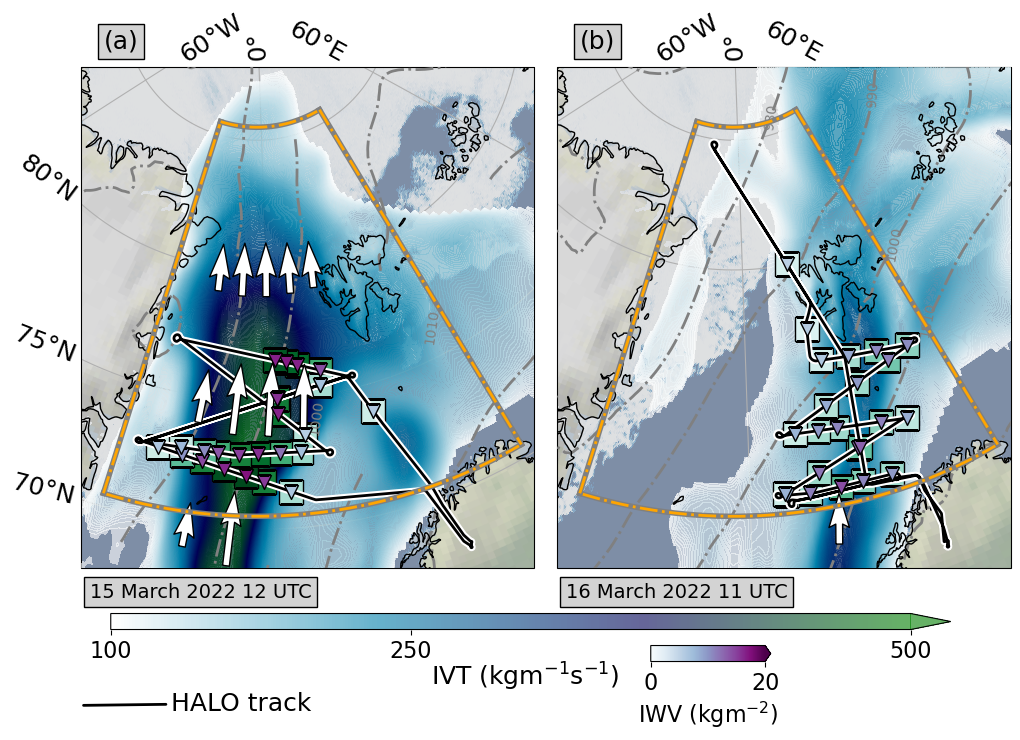

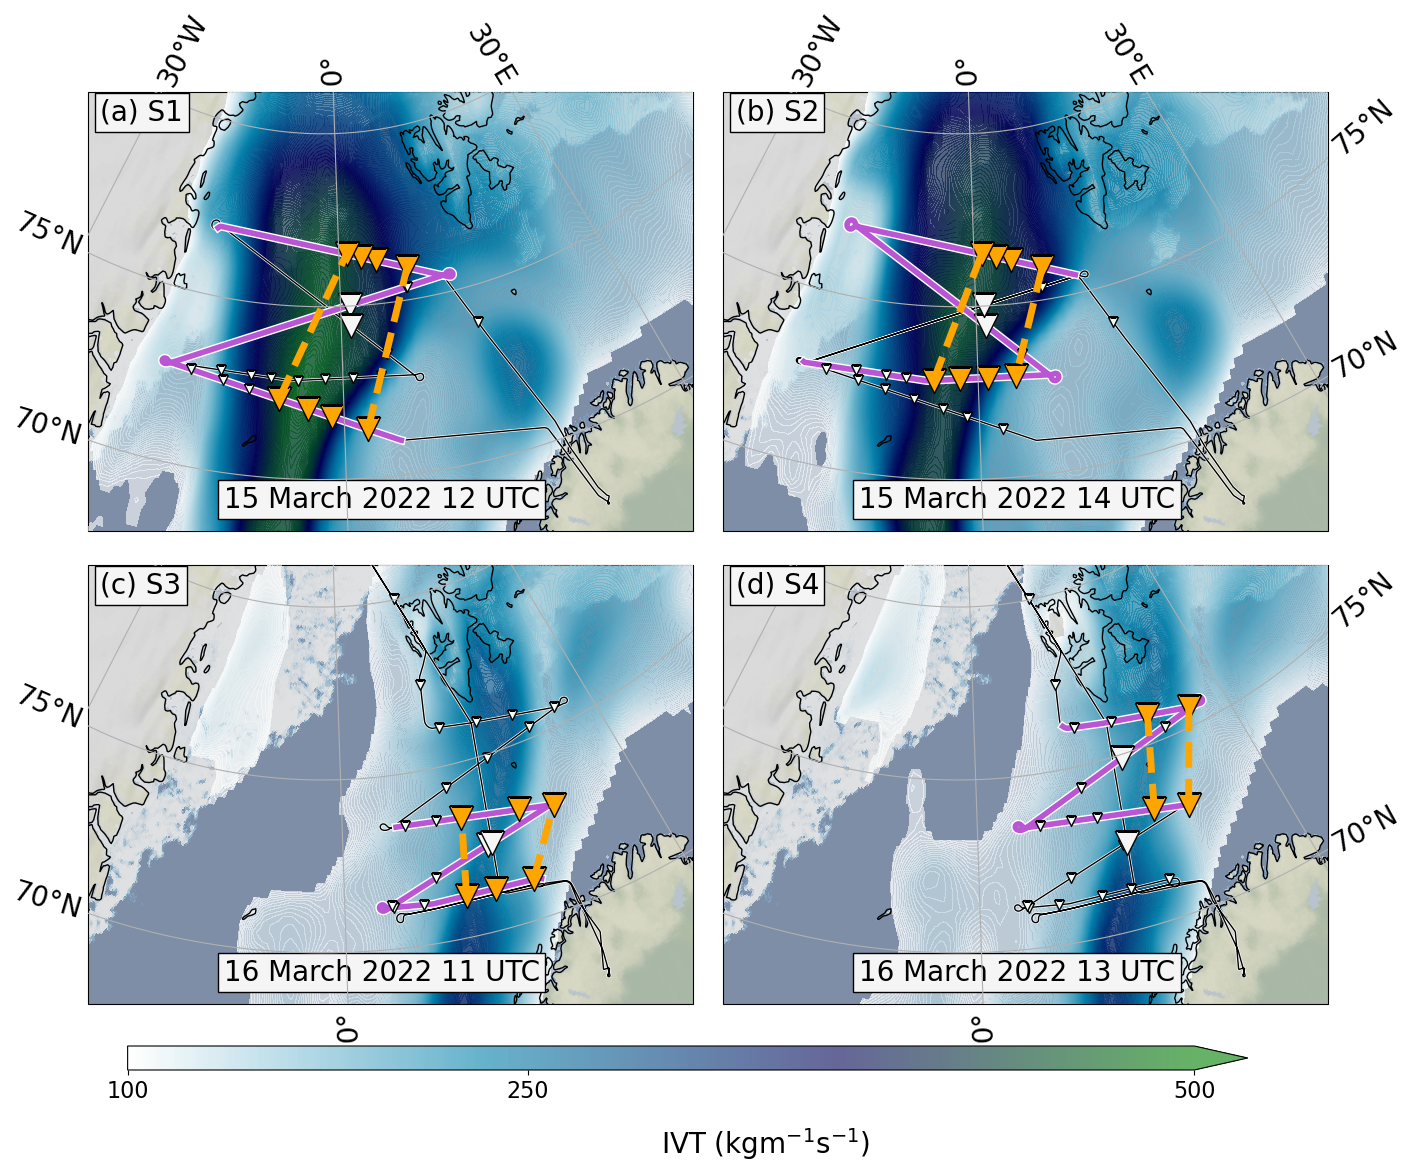

In [17]:
with HiddenPrints():
    ARmaps.run_plot_IVT_tendency()